# Creating a cross section through a RHI scan

In field campaigns with radar systems performing vertical, range-height indicator scans, we can visualize a cross section of LMA points along the plane of the RHI.

In [1]:
import glob
import datetime as dt
import warnings

from pyxlma import coords
from pyxlma.lmalib import lma_intercept_rhi
from pyxlma.lmalib.io import read as lma_read
from pyxlma.lmalib.flash.cluster import cluster_flashes
from pyxlma.lmalib.flash.properties import flash_stats, filter_flashes
from pyxlma.plot.xlma_plot_feature import plot_2d_network_points
from pyxlma.plot.interactive import InteractiveLMAPlot

from cartopy import crs as ccrs
from cartopy import feature as cfeat
from ipywidgets import interact, widgets
from matplotlib import pyplot as plt
from matplotlib.dates import num2date
import numpy as np

%matplotlib widget
warnings.filterwarnings('ignore')

# Read in data

Read in ENTLN csv file and lma .dat.gz (Note: this is not actual ENTLN data, but the csv file included takes the same format of real ENTLN data)

If you ran the previous tutorial, it is possible to read in the netcdf file without having to re-cluster the flashes and re-calculate flash stats.

In [2]:
# Read in our data
entln_data = lma_read.entln('./LEEpulse20221120-trimmed.csv')
# Assign a height AGL of 500m for all CGs so that they show up on plots with a 0 y minimum
entln_data['icheight'] = np.where(entln_data['type'] == 'CG', 500, entln_data['icheight'])

filenames = glob.glob('./LYLOUT_221120_0[8-9]*_0600.dat.gz')
filenames += glob.glob('./LYLOUT_221120_1[0-1]*_0600.dat.gz')
filenames.sort()
lma_data, start_time = lma_read.dataset(filenames)

# Filter events
min_event_stations = 7
max_event_chi2 = 1
good_events = (lma_data.event_stations >= min_event_stations) & (lma_data.event_chi2 <= max_event_chi2)
lma_data = lma_data[{'number_of_events':good_events}]

# Cluster flashes and calculate stats
lma_data = flash_stats(cluster_flashes(lma_data))
# Filter Flashes
min_points_per_flash = 5
big_flash_data = filter_flashes(lma_data, flash_event_count=(min_points_per_flash, None))
big_flash_data

<xarray.Dataset> Size: 1MB
Dimensions:                              (number_of_stations: 16,
                                          number_of_events: 12225,
                                          number_of_flashes: 97)
Coordinates:
  * number_of_stations                   (number_of_stations) int64 128B 0 .....
    event_id                             (number_of_events) uint64 98kB 93112...
  * number_of_flashes                    (number_of_flashes) uint64 776B 1 .....
Dimensions without coordinates: number_of_events
Data variables: (12/47)
    station_network                      (number_of_stations) |S32 512B b'NSS...
    station_name                         (number_of_stations) |S32 512B b'Sit...
    station_latitude                     (number_of_stations) float32 64B 43....
    station_longitude                    (number_of_stations) float32 64B -75...
    station_altitude                     (number_of_stations) float32 64B 358...
    station_delay                        (number_of_stations) float32 64B 100...
    ...                                   ...
    flash_event_count                    (number_of_flashes) uint32 388B 199 ...
    event_parent_flash_id                (number_of_events) uint64 98kB 1 ......
    event_x                              (number_of_events) float64 98kB -692...
    event_y                              (number_of_events) float64 98kB 3.07...
    event_z                              (number_of_events) float32 49kB 2.65...
    flash_id                             (number_of_flashes) uint64 776B 1 .....
Attributes: (12/20)
    title:                    Lightning Mapping Array Dataset, L1b events and...
    production_date:          2024-08-12 15:15:01 +00:00
    production_site:          Default
    institution:              unknown
    comment:                  
    history:                  LMA source file created Wed Jan  4 17:36:30 202...
    ...                       ...
    min_stations:             5
    max_chi2_iterations:      20
    analysis_start_time:      2022-11-20 08:00:00
    analysis_end_time:        2022-11-20 12:00:00
    config_times:             [[[datetime.datetime(2022, 11, 20, 8, 0), datet...
    station_mask_order:       ABCDEFGHNRSTUVWX

# Find an interesting flash to compare to an RHI scan!

This example shows how ipywidgets can be used to interactively explore flashes one at a time.

I set this up to filter to Flash ID 64 when it first plots, because after scrolling around for a few minutes, that flash looks interesting to me to visualize as an RHI. 
(67 is also a good option, try it!)

You can turn off the "filter to flash ID"
checkbox to limit to any aribtrary range to plot later on.

The map is also interactive, try zooming in on the flashes to find an interesting one!

interactive(children=(Checkbox(value=True, description='Filter to Flash ID'), SelectionSlider(description='Fla…

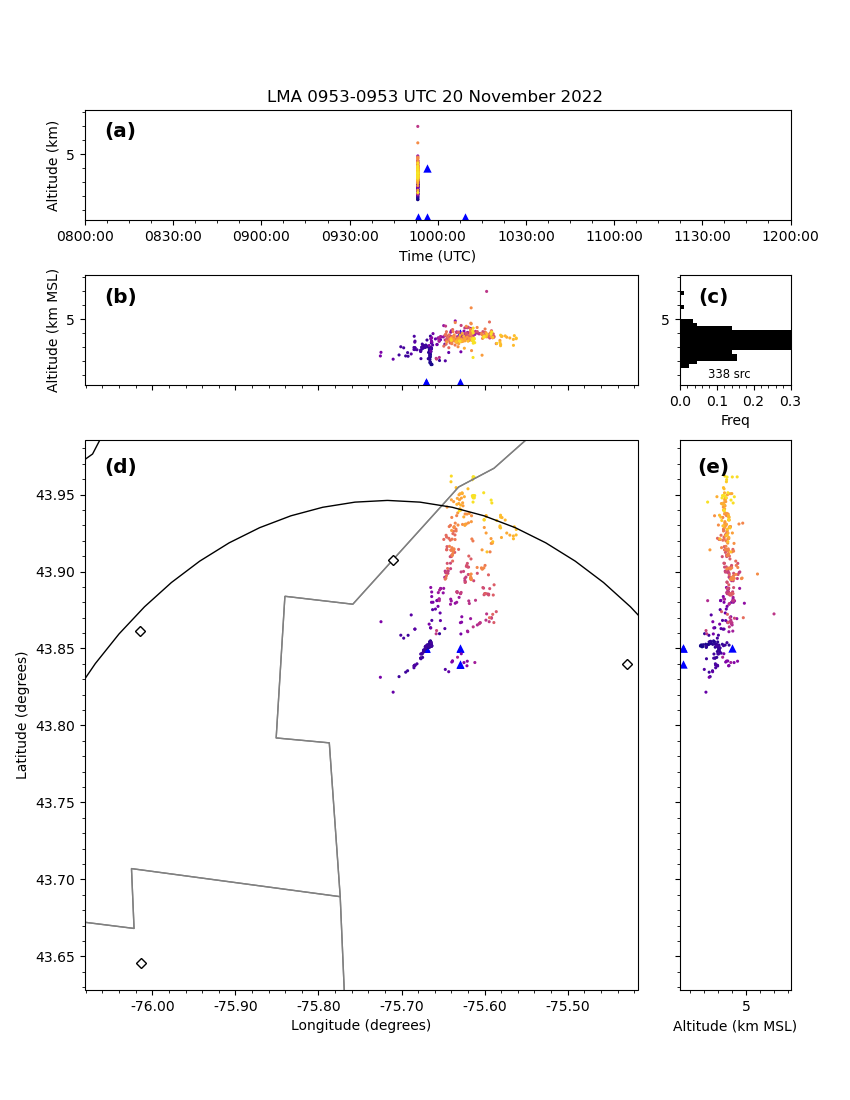

In [3]:
interact_lma = InteractiveLMAPlot(big_flash_data, clon=big_flash_data.network_center_longitude,
                                  clat=big_flash_data.network_center_latitude, tlim=[start_time, start_time + dt.timedelta(hours=4)])
plot_2d_network_points(interact_lma.lma_plot, entln_data, color_by='polarity', actual_height=entln_data['icheight']/1000)


def create_interact(use_flash_id=False, flash_id=0):
    if use_flash_id:
        this_flash = big_flash_data.sel(number_of_flashes=flash_id)
        flash_i_want = this_flash.flash_id.data.item()
        events_in_flash = (this_flash.event_parent_flash_id == flash_i_want)
        this_flash = this_flash[{'number_of_events':events_in_flash}]
        interact_lma.ds = this_flash
        flash_start_time = this_flash.flash_time_start.data.item()
        flash_end_time = this_flash.flash_time_end.data.item()
        interact_lma.bounds['t'] = [flash_start_time, flash_end_time]
    else:
        interact_lma.ds = big_flash_data
        t0, t1 = num2date(interact_lma.lma_plot.ax_th.get_xlim())
        interact_lma.bounds['t'] = (t0.replace(tzinfo=None), t1.replace(tzinfo=None))
    interact_lma.make_plot()
    interact_lma.make_plot_interactive()

use_flash_or_not = widgets.Checkbox(value=True, description='Filter to Flash ID')
flash_id_sel = widgets.SelectionSlider(options=big_flash_data.flash_id.data, description='Flash ID', value=64)
my_widgets = interact(create_interact, use_flash_id=use_flash_or_not, flash_id=flash_id_sel)

# Get the location and time of the points we selected

If you've selected a single flash, it's possible to use the `flash_center_latitude`, `flash_center_longitude`, `flash_center_altitude`, and `flash_time_start`/`flash_time_end` variables without recalculating anything.
However, for an arbitrary range of points, the averages of these variables must be obtained to get the most representative radar scan.

In [4]:
selected_data = interact_lma.ds.copy()
center_lon = selected_data.event_longitude.mean(dim='number_of_events').data.item()
center_lat = selected_data.event_latitude.mean(dim='number_of_events').data.item()
center_alt = selected_data.event_altitude.mean(dim='number_of_events').data.item()

selected_time = selected_data.event_time.mean(dim='number_of_events')
# Convert that to a standard python datetime. This loses nanosecond precision, but allows the time to be used in nexradaws
selected_time = selected_time.data.astype('datetime64[us]').astype(dt.datetime).item()
print(selected_time)

2022-11-20 09:53:12.726044


In [5]:
import nexradaws
conn = nexradaws.NexradAwsInterface()
radar_id = 'KTYX'

range_start = selected_time - dt.timedelta(minutes=5)
range_end = selected_time + dt.timedelta(minutes=5)

scans = conn.get_avail_scans_in_range(range_start, range_end, radar_id)
scans = [scan for scan in scans if 'MDM' not in scan.filename]
print(scans)


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119

[<AwsNexradFile object - 2022/11/20/KTYX/KTYX20221120_095249_V06>]


The radar scan closest to our flash took place at 09:52:49 UTC. Download that one.

In [6]:
radar_download = conn.download(scans[-1], '.')

Downloaded KTYX20221120_095249_V06
1 out of 1 files downloaded...0 errors


In [7]:
import pyart
import cmweather
radar_file_path = radar_download.success[0].filepath # try changing this to a string with the path to your own data!
radar = pyart.io.read(radar_file_path)
print(list(radar.fields.keys()))

['differential_phase', 'cross_correlation_ratio', 'reflectivity', 'differential_reflectivity', 'velocity', 'spectrum_width', 'clutter_filter_power_removed']


Now, create a map of the reflectivity with the LMA points!

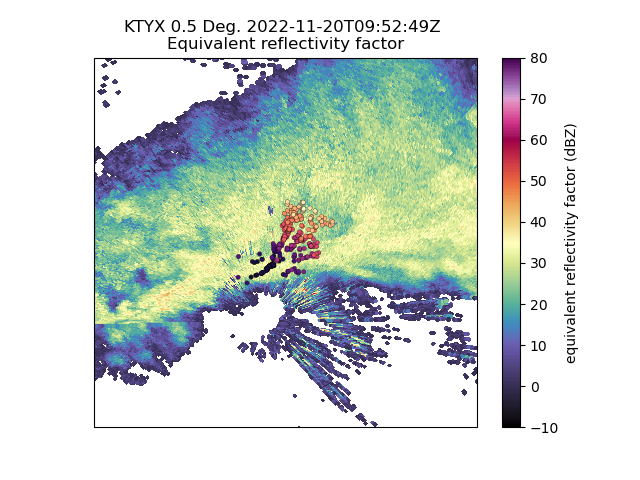

In [8]:
field_i_want = 'reflectivity'
radar_fig = plt.figure()
radar_ax = plt.axes(projection=ccrs.PlateCarree())

rmd = pyart.graph.RadarMapDisplay(radar)
# Here I mask out reflectivities below 0 dBZ to get rid of some of the ground clutter.
rmd.plot_ppi_map(field_i_want, mask_tuple=('reflectivity', 0), vmin=-10, vmax=80, cmap='ChaseSpectral', ax=radar_ax, fig=radar_fig, add_grid_lines=False)

radar_ax.scatter(selected_data.event_longitude, selected_data.event_latitude, c=selected_data.event_time, cmap='magma', s=10, edgecolor='k', linewidths=0.2, transform=ccrs.PlateCarree())
radar_ax.set_extent([selected_data.event_longitude.data.min()-0.25, selected_data.event_longitude.data.max()+0.25,
                   selected_data.event_latitude.data.min()-0.25, selected_data.event_latitude.data.max()+0.25])

Using the flash_center variables, find the azimuth of the flash from the perspective of the radar to build a psuedo-RHI from

In [9]:
radar_lon = radar.longitude['data'][0]
radar_lat = radar.latitude['data'][0]
radar_alt = radar.altitude['data'][0]
radar_time = pyart.util.datetime_from_radar(radar)

plate_carree_projection = coords.GeographicSystem()
radar_coords = coords.RadarCoordinateSystem(radar_lat, radar_lon, radar_alt)

selected_data.flash_center_longitude.data, selected_data.flash_center_latitude.data, selected_data.flash_center_altitude.data
flash_range, flash_azimuth, flash_elevation = radar_coords.fromECEF(*plate_carree_projection.toECEF(selected_data.flash_center_longitude.data, selected_data.flash_center_latitude.data, selected_data.flash_center_altitude.data))
flash_range = flash_range[0]
flash_azimuth = flash_azimuth[0]
flash_elevation = flash_elevation[0]
print(f'Flash center is located at azimuth {flash_azimuth:.1f}°, elevation of {flash_elevation:.1f}°, and range of {flash_range:.1f}m')

Flash center is located at azimuth 13.2°, elevation of 10.3°, and range of 15925.3m


Make an RHI plot of the nearest azimuth to the flash centroid

(0.0, 10.0)

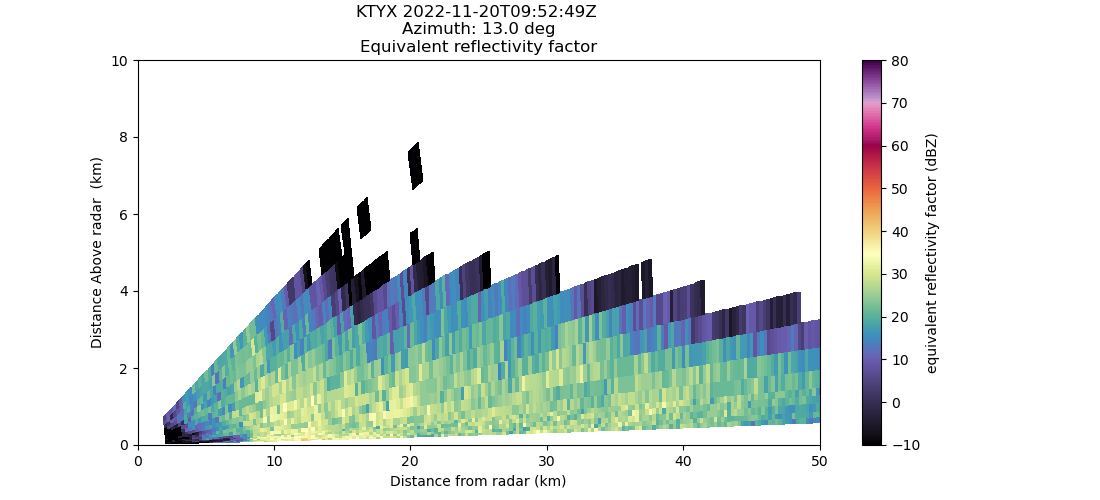

In [10]:
rhi_fig = plt.figure(figsize=(11, 5))
rhi_ax = rhi_fig.gca()
rmd.plot_azimuth_to_rhi(field_i_want, int(flash_azimuth), vmin=-10, vmax=80, cmap='ChaseSpectral', ax=rhi_ax, fig=rhi_fig)
rhi_ax.set_xlim([0, 50])
rhi_ax.set_ylim([0, 10])

Transform the LMA points from lat/lon/altitude to range along the RHI plane, distance from the plane, and height above the radar. Add these transformed points to the above figure. If the LMA data were not already filtered to a single flash, the `distance_threshold` keyword argument could be used to filter to sources that are close (spatially) to the RHI plane, and the `time_threshold` could be used to filter to sources that are close temporally. Since the LMA data is already filtered to a single flash that is close to the RHI time, and the RHI goes through the center of the flash, set these to None to disable this filtering.

In [11]:
lma_range, lma_distance, lma_ARL, point_mask = lma_intercept_rhi.find_lma_points_near_rhi(selected_data, radar_lat, radar_lon, radar_alt, int(flash_azimuth), radar_time, distance_threshold=None, time_threshold=None)
sec_since_flash_start = (selected_data.event_time[point_mask] - np.min(selected_data.flash_time_start.data)).astype(float)/1e6
pcm = rhi_ax.scatter(lma_range/1000, lma_ARL/1000, c=sec_since_flash_start, cmap='magma', s=10, edgecolor='k', linewidths=0.2)
rhi_fig.colorbar(pcm, label='Time since flash initiation (ms)')

Add ENTLN data along the ground for LMA verification

In [12]:
negative_cg_range, negative_cg_distance, negative_cg_ARL, negative_cg_mask = lma_intercept_rhi.find_points_near_rhi(
    entln_data['longitude'], entln_data['latitude'], np.zeros_like(entln_data['longitude']), entln_data['datetime'],
    radar_lat, radar_lon, radar_alt, int(flash_azimuth), radar_time, distance_threshold=None, time_threshold=None)


rhi_ax.scatter(negative_cg_range/1000, entln_data['icheight']/1000, c='blue', marker='X')